In [2]:
import numpyro
#numpyro.set_platform("cpu")
import jax
import jax.numpy as jnp
import jax.random as jr 
import numpyro.distributions as dist

from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, List, Callable
import sys
sys.path.append("../")
from utils import plot_testset, get_data, minmaxrmspe, plot_samples


Training data: (150, 7) (150, 102)
Testing data: (300, 7) (300, 102)


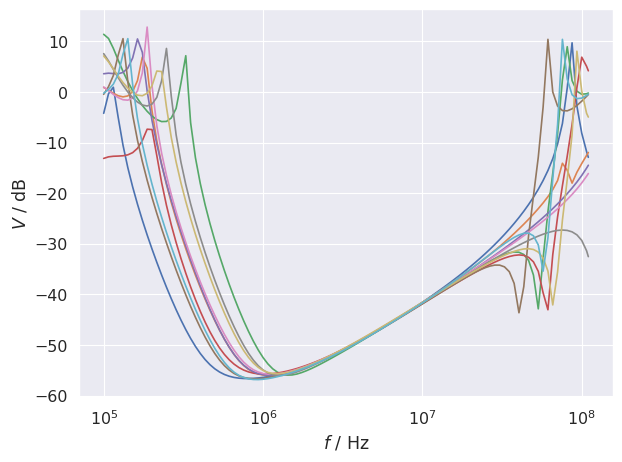

In [4]:
data = jnp.load("../data/data_ayush.npz")
X, Y, f = data["X"], data["Y"], data["f"]

data_key = jr.PRNGKey(0)
(X_train, Y_train), (X_test, Y_test), (X_val, Y_val) = get_data(
                                                            X, 
                                                            Y, 
                                                            f,               
                                                            split=(0.3,0.6), 
                                                            key=data_key,
                                                            dense=False
                                                        )
print("Training data:",X_train.shape, Y_train.shape)
print("Testing data:", X_test.shape, Y_test.shape)

sns.set_theme("paper",style="darkgrid",font_scale=1.3)
fig, ax = plt.subplots()
ax.plot(f,Y_train[:10].T)
ax.set_xscale("log")
ax.set_ylabel(r"$V$ / dB")
ax.set_xlabel(r"$f$ / Hz" )
#plt.title(r"Frequency response for some sampels $\bf X$")
plt.tight_layout()
plt.savefig("../plots/data_samples.png", dpi=300, )

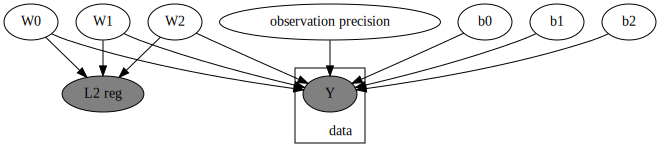

In [81]:
def dense_layer(
        i: int,
        size: List[int],
):  
    #Xavier initialization
    alpha_sq = 2/(size[0] + size[1])
    alpha_sq = 1.0
    W = numpyro.sample(f"W{i}", dist.Normal(0, alpha_sq**0.5).expand(size))
    b = numpyro.sample(f"b{i}", dist.Normal(0, alpha_sq**0.5).expand((size[-1],)))
    return W, b

def forward(
        W: List[jax.Array],
        b: List[jax.Array],
        X: jax.Array,
        activation: Callable,
):
    #input layer
    z = activation(jnp.dot(X, W[0]) + b[0])

    #hidden layers
    for i in range(1, len(W) - 1):
        z = activation(jnp.dot(z, W[i]) + b[i])

    #output layer with no activation
    z = jnp.dot(z, W[-1]) + b[-1]
    return z.squeeze()

def wideband_dnn(
        X: jax.Array,
        Y: jax.Array,
        layers: List[int],
):
    N, input_dim = X.shape
    activation = jax.nn.relu
    W = []
    b = []
    #build the layers with the given list
    for i, layer in enumerate(layers):
        W_, b_ = dense_layer(i, [input_dim, layer])
        W.append(W_)
        b.append(b_)
        input_dim = layer
    #forward pass through the network
    z = forward(W, b, X, activation)
    if Y is not None:
        assert Y.shape == z.shape , f"Y shape {Y.shape} does not match z shape {z.shape}"

    precision_obs = numpyro.sample(r"observation precision", dist.Gamma(3., 1.))
    sigma_obs = 1.0 / jnp.sqrt(precision_obs)

    with numpyro.plate("data", N):
        numpyro.sample(
            "Y", 
            dist.Normal(z, sigma_obs).to_event(1), 
            obs=Y
        )
    #L2 regularization
    w_squared = 0
    for w in W:
        w_squared += jnp.sum(jnp.square(w))
    numpyro.factor("L2 reg", 0.1 * w_squared)

    

LAYERS = [128, 128, Y.shape[-1]]

try:
    render = numpyro.render_model(wideband_dnn, (X_train, Y_train, LAYERS))
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")
render

In [82]:
#inference with svi
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoLaplaceApproximation, AutoMultivariateNormal, AutoIAFNormal, AutoLowRankMultivariateNormal, AutoDelta

guide = AutoDiagonalNormal(wideband_dnn)


svi = SVI(
    wideband_dnn, guide, numpyro.optim.Adam(0.05), Trace_ELBO()
)

svi_result = svi.run(
    jax.random.PRNGKey(0),
    num_steps=3000,
    X=X_train,
    Y=Y_train,
    layers=LAYERS
)

100%|██████████| 3000/3000 [00:01<00:00, 1612.12it/s, init loss: 27079160.0000, avg. loss [2851-3000]: 50568.7578]


In [83]:
def predict_new(
        svi_result,
        guide,
        X_test: jax.Array,
        num_samples: int = 500,
        *,
        key: jr.key,
        return_mean: bool = True,
    )-> Tuple:
    
    sample_key, prediction_key = jr.split(key, 2)
    #sample from the trained guide
    samples = guide.sample_posterior(
        sample_key, svi_result.params, sample_shape=(num_samples, )
    )
    #define predictive distribution with samples and the model.
    predictive_distribution = Predictive(
        wideband_dnn, samples, return_sites=["Y"]
    )
    #sample from the predictive distribution given new test points
    predictions = predictive_distribution(
        prediction_key, X_test, None, LAYERS
    )
    if return_mean is True:
        return jnp.mean(predictions["Y"], axis=0), jnp.var(predictions["Y"], axis=0)
    else:
        return jnp.mean(predictions["Y"], axis=0), jnp.var(predictions["Y"], axis=0), predictions

mean, var, samples = predict_new(
    svi_result, 
    guide,  
    X_test,
    num_samples = 6000, 
    key = jr.key(1),
    return_mean=False
)
    

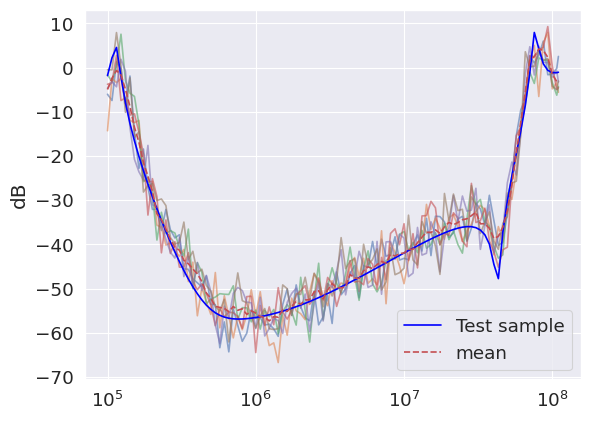

In [84]:
samples["Y"].shape
plot_samples(
    f, Y_test[0], mean[0], samples["Y"][0:6,0].T
)

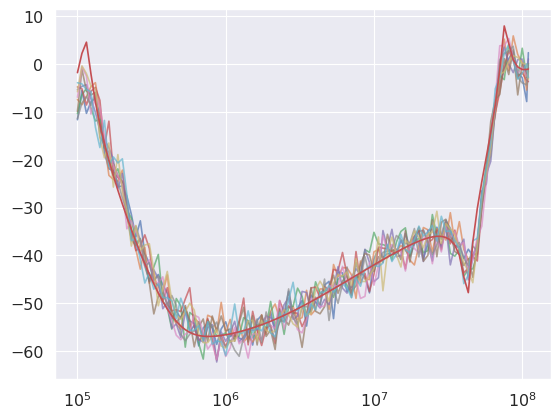

In [25]:
plt.plot(f, samples["Y"][0:10,0,:].T, alpha = 0.7)
plt.plot(f, Y_test[0], "r")
plt.xscale("log")

minmaxrmspe: 5.265447


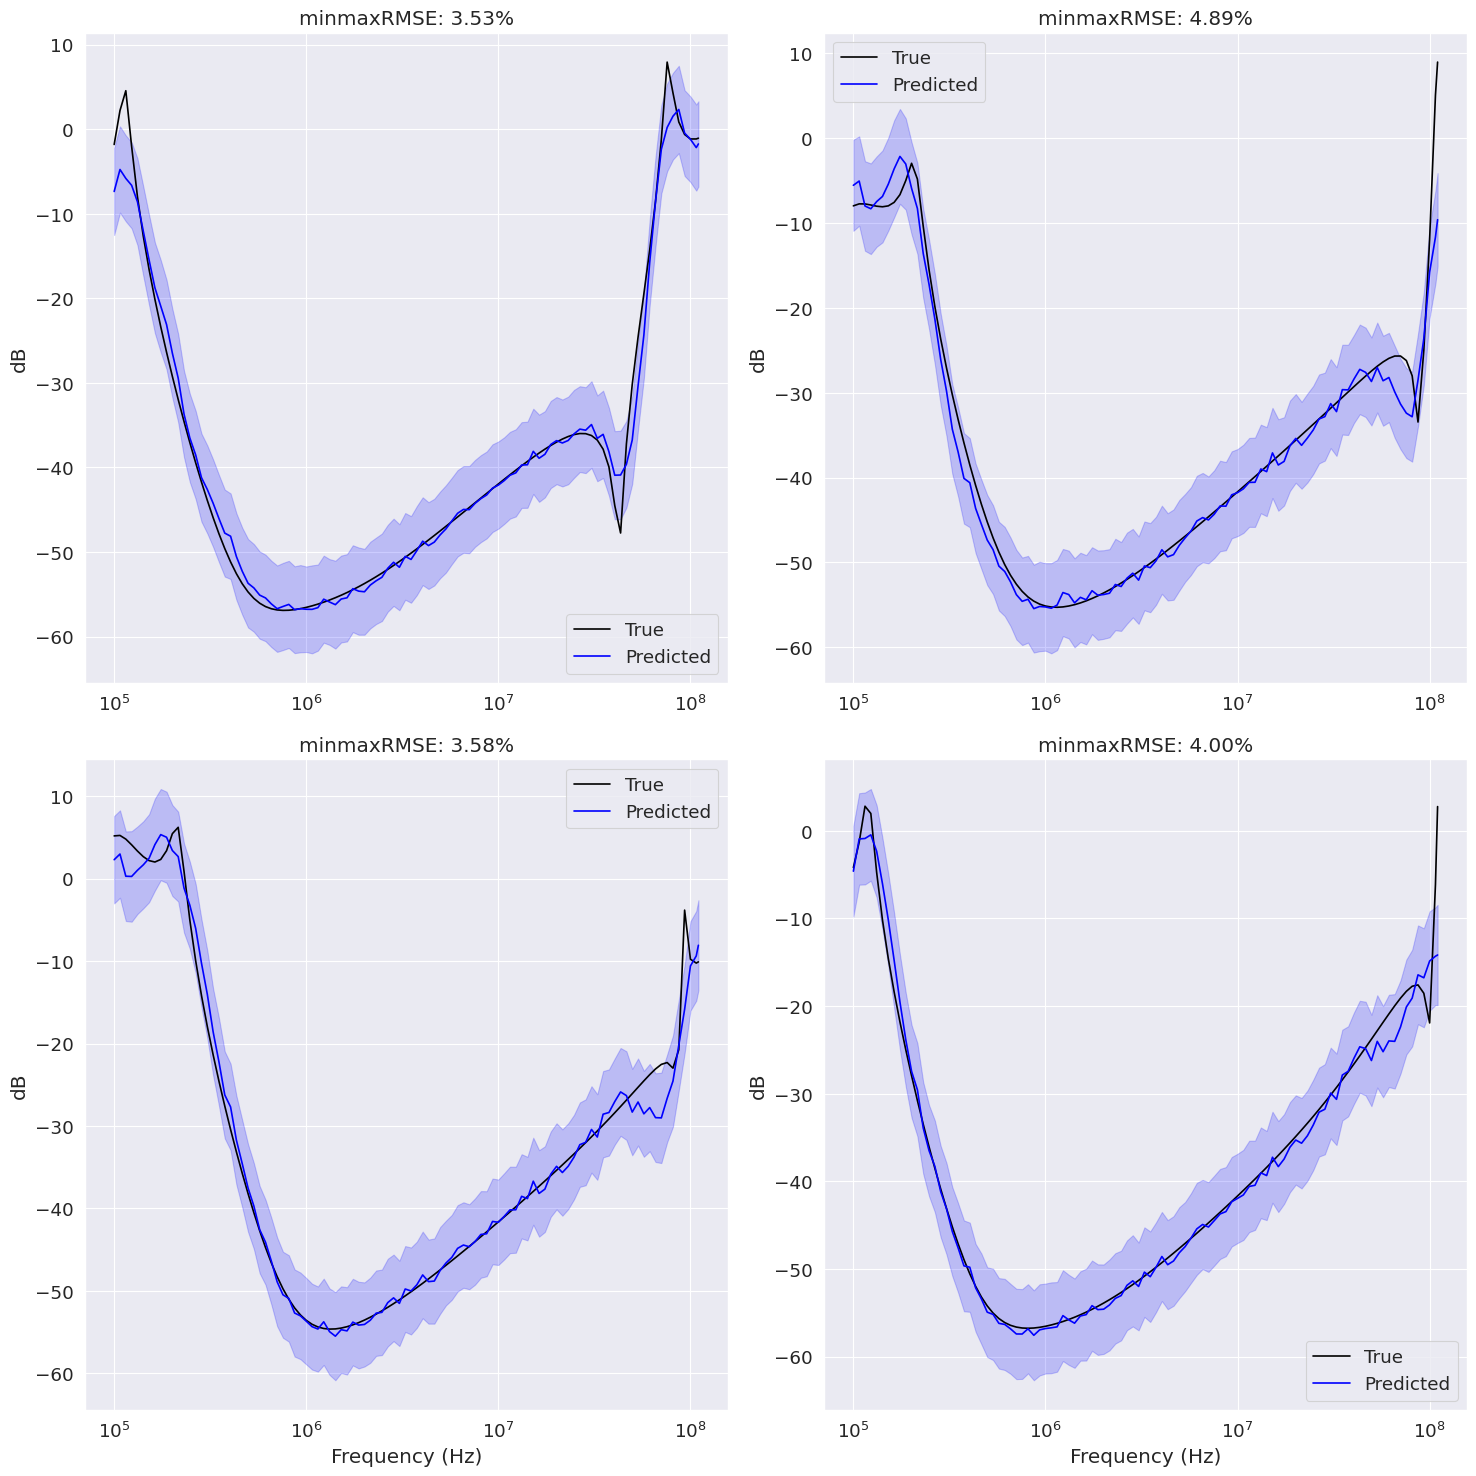

In [32]:
sns.set_theme("paper",font_scale=1.5)
print("minmaxrmspe:", minmaxrmspe(Y_test, mean))
fig, ax = plot_testset(f, Y_test, mean, var, grid=(2,2), figsize=(15,15))
plt.savefig("../plots/prediction_transformer")
